In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Carregar o modelo

In [2]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
# outputs = predictor(im)

[12/09 11:49:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


Carregar dataset de car-damage

In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import MetadataCatalog, DatasetCatalog

# !curl -L "https://universe.roboflow.com/ds/5sncDNZAeT?key=lgL2BuIUSz" > roboflow.zip; unzip roboflow.zip -d datasets/car-damage-s4; rm roboflow.zip
# !curl -L "https://universe.roboflow.com/ds/R0WssxzPHH?key=DrYHDd0r3w" > roboflow.zip; unzip roboflow.zip -d datasets/severity; rm roboflow.zip


# Replace with paths to your dataset
# register_coco_instances("car-damage-v8-train", {}, "datasets/car-damage-v8/train/_annotations.coco.json", "datasets/car-damage-v8/train")
# register_coco_instances("car-damage-v8-test", {}, "datasets/car-damage-v8/valid/_annotations.coco.json", "datasets/car-damage-v8/valid")
# register_coco_instances("car-damage-s4-train", {}, "datasets/car-damage-s4/train/_annotations.coco.json", "datasets/car-damage-s4/train")
# register_coco_instances("car-damage-s4-test", {}, "datasets/car-damage-s4/test/_annotations.coco.json", "datasets/car-damage-s4/test")
register_coco_instances("severity-train", {}, "datasets/severity/train/_annotations.coco.json", "datasets/severity/train")
register_coco_instances("severity-test", {}, "datasets/severity/test/_annotations.coco.json", "datasets/severity/test")
register_coco_instances("severity-val", {}, "datasets/severity/valid/_annotations.coco.json", "datasets/severity/valid")

# Verify if the dataset is correctly registered
my_dataset_metadata = MetadataCatalog.get("severity-train")
dataset_dicts = DatasetCatalog.get("severity-train")



WARNING [12/09 11:49:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 11:49:56 d2.data.datasets.coco]: Loaded 3640 images in COCO format from datasets/severity/train/_annotations.coco.json


Printar resultados

WARNING [12/09 11:50:05 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 11:50:05 d2.data.datasets.coco]: Loaded 634 images in COCO format from datasets/severity/test/_annotations.coco.json


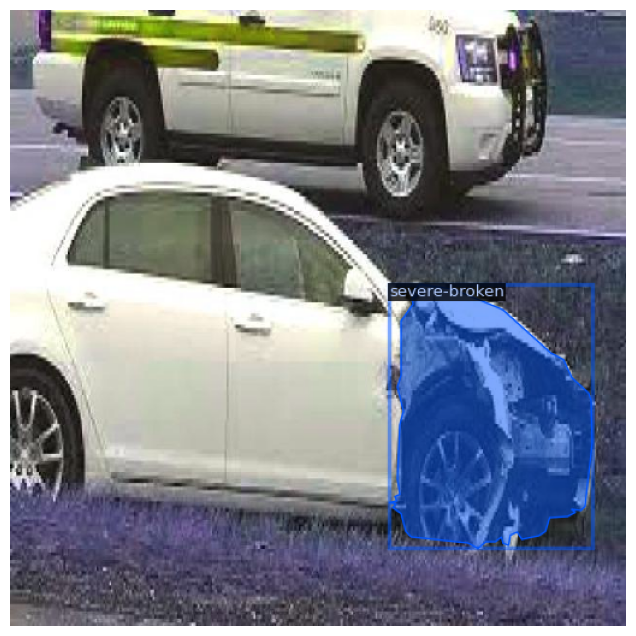

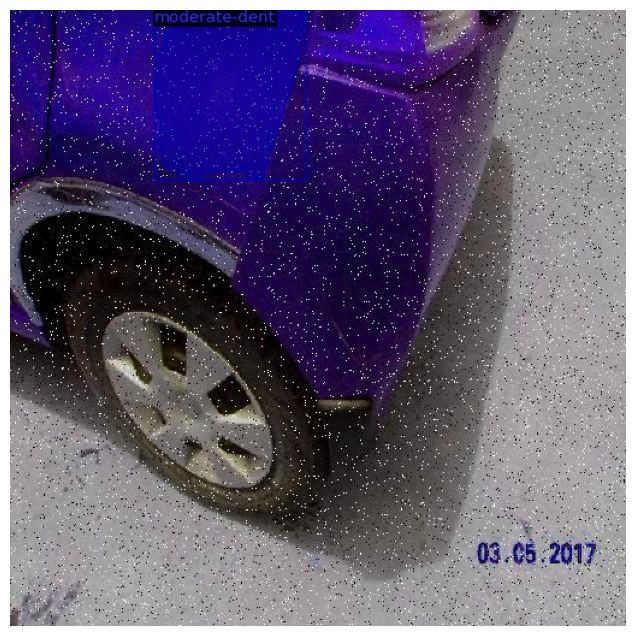

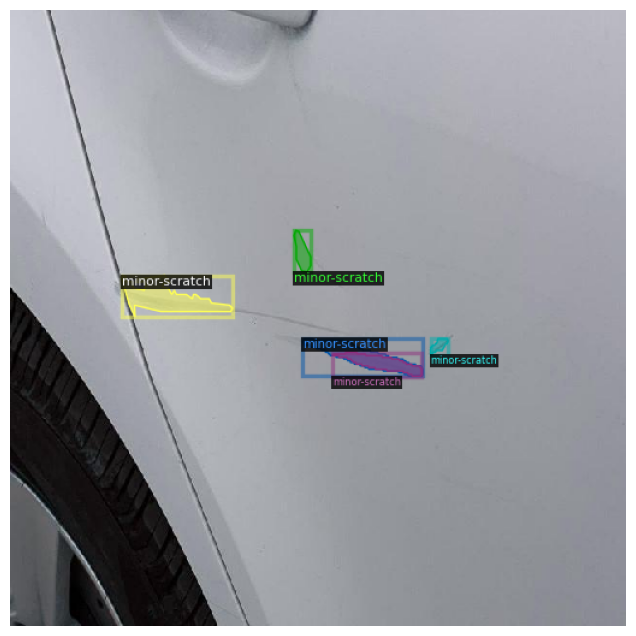

In [4]:
''
from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

# Get the dataset metadata and dataset dicts
dataset_dicts = DatasetCatalog.get("severity-test")
metadata = MetadataCatalog.get("severity-test")

# Plot a few random images from the dataset
for d in random.sample(dataset_dicts, 3):  # Change the number to print more or fewer images
    img = cv2.imread(d["file_name"])

    # Create a visualizer and draw annotations (bounding boxes, etc.)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
    vis = visualizer.draw_dataset_dict(d)

    # Display the image with matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

Selecionar modelo e treinar dataset de treino

In [5]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")) #
cfg.DATASETS.TRAIN = ("severity-train",)
cfg.DATASETS.TEST = ("severity-test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300 #2000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8
#cfg.OUTPUT_DIR = "./output"

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[12/09 11:50:16 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (8, 256, 1, 1) 

[12/09 11:50:16 d2.engine.train_loop]: Starting training from iteration 0


/home/ricardofachini/miniconda3/envs/visao-computacional/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647380992/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/09 11:50:22 d2.utils.events]:  eta: 0:01:06  iter: 19  total_loss: 3.749  loss_cls: 1.886  loss_box_reg: 0.2462  loss_mask: 0.6916  loss_rpn_cls: 0.8378  loss_rpn_loc: 0.1122    time: 0.2411  last_time: 0.2793  data_time: 0.0065  last_data_time: 0.0022   lr: 1.6068e-05  max_mem: 1945M
[12/09 11:50:26 d2.utils.events]:  eta: 0:01:01  iter: 39  total_loss: 2.706  loss_cls: 1.4  loss_box_reg: 0.1157  loss_mask: 0.6879  loss_rpn_cls: 0.3049  loss_rpn_loc: 0.04982    time: 0.2378  last_time: 0.2332  data_time: 0.0023  last_data_time: 0.0023   lr: 3.2718e-05  max_mem: 1945M
[12/09 11:50:31 d2.utils.events]:  eta: 0:00:56  iter: 59  total_loss: 2.304  loss_cls: 0.7447  loss_box_reg: 0.2439  loss_mask: 0.6818  loss_rpn_cls: 0.3976  loss_rpn_loc: 0.05603    time: 0.2389  last_time: 0.1804  data_time: 0.0024  last_data_time: 0.0023   lr: 4.9367e-05  max_mem: 1945M
[12/09 11:50:36 d2.utils.events]:  eta: 0:00:52  iter: 79  total_loss: 1.453  loss_cls: 0.3961  loss_box_reg: 0.156  loss_mask: 0

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

Evaluate

In [6]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import os

# Configurações para o modelo treinado
# cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # Caminho para o modelo salvo
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Ajuste o threshold de detecção, se necessário
# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)


[12/09 11:52:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/home/ricardofachini/miniconda3/envs/visao-computacional/lib/python3.9/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return to

Visualizar resultado

In [7]:
from detectron2.utils.visualizer import ColorMode

# car_metadata = MetadataCatalog.get("severity-train")


dataset_dicts = DatasetCatalog.get("severity-test")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(outputs["instances"].pred_classes)  # Classes preditas
    print(outputs["instances"].pred_boxes)
    cv2.imshow("w", out.get_image()[:, :, ::-1])
    cv2.waitKey(0)

    # Close the window after the key press
    cv2.destroyAllWindows()


WARNING [12/09 11:53:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/09 11:53:27 d2.data.datasets.coco]: Loaded 634 images in COCO format from datasets/severity/test/_annotations.coco.json
tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))
tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))
tensor([], device='cuda:0', dtype=torch.int64)
Boxes(tensor([], device='cuda:0', size=(0, 4)))


Testar uma imagem qualquer